In [163]:
"""
Qick DRAM based Trace Average Test
Signal -> Demodulator -> FIR & x8 decimation -> PL DRAM
After decimated signals are saved on DRAM (this measurement is implemented on FPGA),
and we get all trace data from DRAM and average it in software.
Note that data trace data should not exceed 4 GB and virtual memory allocated
for RPC Server in RFSoC (I don't know how can we estimate virtual memory allocation...).
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.pyro import make_proxy

class MultiPulseLoopBackExample(AveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 1         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = 100,      # Readout length
        )
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = 100,      # Readout DDS multiplication length
            phrst   = 0         # Readout DDS phase reset
        )
        self.synci(100)
    def body(self):
        cfg = self.cfg
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 500, # Readout will capture the data @ sync_t + 50
            ddr4    = True
        )
        self.setup_and_pulse(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),  # Generator DDS phase
            gain    = cfg["gain"],        # Generator amplitude
            phrst   = 0,        # Generator DDS phase reset
            mode    = "periodic", # Set pulse mode to periodic
            length  = 100,
            t       = 1000
        )
        self.safe_regwi(0, 6, cfg["pulse_time"])
        self.sync(0, 6)
        self.set_timestamp(0, gen_ch=0)
        self.setup_and_pulse(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),  # Generator DDS phase
            gain    = 0,        # Generator amplitude
            phrst   = 0,        # Generator DDS phase reset
            mode    = "periodic", # Set pulse mode to periodic
            length  = 100,
            t       = 100
        )


def analyze_iq_and_fft(
    data,
    dt_ns=10/3,
    start_idx=1000,
    stop_idx=5000,
    include_end=True,
    window="hann",
    signal_bins=2,
    guard_bins=4,
    exclude_dc_from_noise=False
):
    if isinstance(data, (tuple, list)) and len(data) == 2:
        i, q = data
        i = np.asarray(i)
        q = np.asarray(q)
        x = i.astype(np.float64) + 1j * q.astype(np.float64)
    else:
        x = np.asarray(data).astype(np.complex128)

    N_total = x.size

    stop_eff = stop_idx + 1 if include_end else stop_idx
    seg = x[start_idx:stop_eff]
    N = seg.size

    fs = 1.0 / (dt_ns * 1e-9)
    dt = 1.0 / fs
    df = fs / N

    if isinstance(window, str):
        wname = window.lower()
        if wname in ("hann", "hanning"):
            win = np.hanning(N)
        elif wname in ("hamming",):
            win = np.hamming(N)
        elif wname in ("rect", "rectangular", "boxcar"):
            win = np.ones(N)

    U = (win**2).mean()
    CG = win.mean()
    ENBW_bins = N * (win**2).sum() / (win.sum()**2)
    ENBW_hz = ENBW_bins * df

    xw = seg * win
    X = np.fft.fft(xw)
    f = np.fft.fftfreq(N, d=dt)
    Sxx = (np.abs(X)**2) / (fs * N * U)

    Xs  = np.fft.fftshift(X)
    Ss  = np.fft.fftshift(Sxx)
    fx  = np.fft.fftshift(f)

    peak_idx = int(np.argmax(Ss))
    sig_lo = max(0, peak_idx - signal_bins)
    sig_hi = min(N, peak_idx + signal_bins + 1)

    mask_signal = np.zeros(N, dtype=bool)
    mask_signal[sig_lo:sig_hi] = True

    mask_noise = ~mask_signal
    guard_lo = max(0, peak_idx - (signal_bins + guard_bins))
    guard_hi = min(N, peak_idx + (signal_bins + guard_bins) + 1)
    mask_noise[guard_lo:guard_hi] = False

    if exclude_dc_from_noise:
        dc_idx = int(np.argmin(np.abs(fx)))
        mask_noise[dc_idx] = False

    Psig   = Ss[mask_signal].sum() * df
    Pnoise = Ss[mask_noise].sum() * df
    SNR_dB = 10*np.log10(Psig / Pnoise) if Pnoise > 0 else np.inf

    noise_psd_mean   = Ss[mask_noise].mean() if mask_noise.any() else np.nan
    noise_psd_median = np.median(Ss[mask_noise]) if mask_noise.any() else np.nan
    noise_floor_mean_dBc_per_Hz   = 10*np.log10(noise_psd_mean   / Psig) if (Psig>0 and noise_psd_mean>0) else np.nan
    noise_floor_median_dBc_per_Hz = 10*np.log10(noise_psd_median / Psig) if (Psig>0 and noise_psd_median>0) else np.nan

    return {
        "fs_hz": fs, "df_hz": df, "dt_s": dt, "N": N,
        "window": wname, "U": U, "coherent_gain": CG,
        "ENBW_bins": ENBW_bins, "ENBW_hz": ENBW_hz,
        "start_idx": start_idx, "stop_idx_inclusive": stop_idx if include_end else stop_idx-1,
        "f_axis_hz": fx, "fft_shifted": Xs, "psd_shifted": Ss,
        "peak_freq_hz": fx[peak_idx],
        "signal_power": Psig, "noise_power": Pnoise, "SNR_dB": SNR_dB,
        "noise_psd_mean": noise_psd_mean,
        "noise_psd_median": noise_psd_median,
        "noise_floor_mean_dBc_per_Hz": noise_floor_mean_dBc_per_Hz,
        "noise_floor_median_dBc_per_Hz": noise_floor_median_dBc_per_Hz,
        "signal_bins_each_side": signal_bins,
        "guard_bins_each_side": guard_bins,
    }

def plot_fft_magnitude(result, normalize_to_peak=True, title=None):
    fx_mhz = result["f_axis_hz"] / 1e6
    Xs = result["fft_shifted"]
    mag = np.abs(Xs)
    if normalize_to_peak:
        mag = mag / (mag.max() + 1e-300)
    y_db = 20*np.log10(np.maximum(mag, 1e-300))

    plt.figure()
    plt.plot(fx_mhz, y_db)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title or "FFT Magnitude (normalized)")
    plt.grid(True)
    plt.tight_layout()

def plot_psd(result, ref_to_carrier=True, title=None):
    fx_mhz = result["f_axis_hz"] / 1e6
    Ss = result["psd_shifted"]
    if ref_to_carrier and result["signal_power"] > 0:
        y_db = 10*np.log10(np.maximum(Ss / result["signal_power"], 1e-300))
        ylabel = "PSD (dBc/Hz)"
    else:
        y_db = 10*np.log10(np.maximum(Ss, 1e-300))
        ylabel = "PSD (dB/Hz, arbitrary)"

    plt.figure()
    plt.plot(fx_mhz, y_db)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel(ylabel)
    plt.title(title or "Power Spectral Density")
    plt.grid(True)
    plt.tight_layout()



Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_38f24800b8e744bfb6326c66ea9ca7fa@192.168.2.99:38083

// Program

        regwi 4, $22, 966367640;                //freq = 966367640
        regwi 4, $26, 16;                       //mode | outsel = 0b00000 | length = 16 
        synci 100;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 4, $27, 100;                      //t = 100
        set 4, 4, $22, $0, $26, $0, $26, $27;   //ch = 0, pulse @t = $27
        regwi 0, $16, 1;                        //out = 0b0000000000000001
        seti 7, 0, $16, 0;                      //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 10;                      //ch =0 out = 0 @t = 0
        regwi 0, $22, 362387865;                //freq = 362387865
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1000;                     //gain = 1000
        regwi 0, $26, 597824;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 8

100%|██████████| 1/1 [00:00<00:00, 257.79it/s]

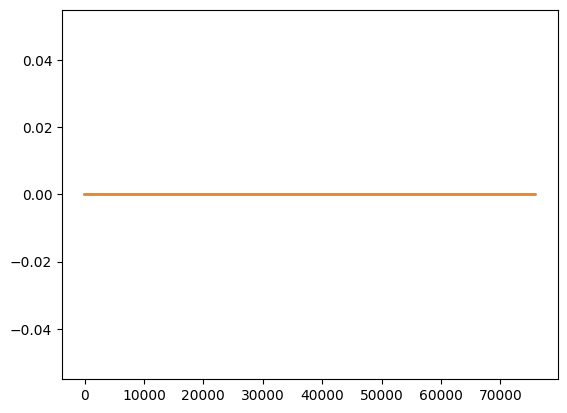

Acquisition Time: 0.046 s
SNR : inf dB


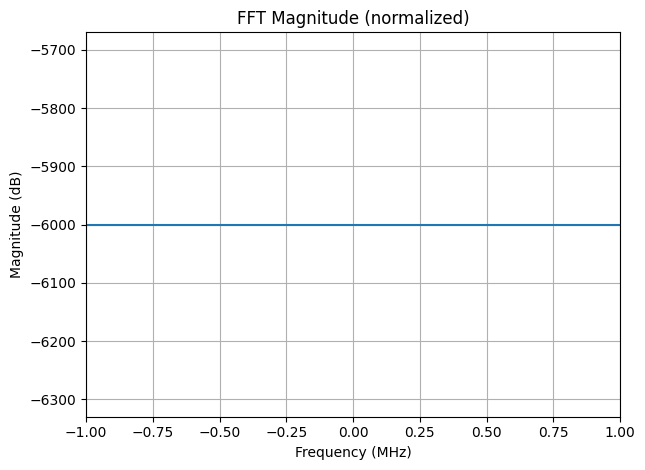

In [ ]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,30)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

cfg = {
    # Experiment Setup
    "reps"          : 1,
    "soft_avgs"     : 1,
    # Parameter Setup
    "freq_rf" : 540,
    "gain" : 20000,
    "pulse_time" : 100000,
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = int(cfg["pulse_time"] * 3 / 4) + 1024
nt = int(LEN / 128)
start_time = time.time()
soc.clear_ddr4()
soc.arm_ddr4(ch = 0, nt = nt)
print(prog)
prog.run_rounds(soc = soc)
data = soc.get_ddr4(nt = nt, start = 0)
mean_end_time = time.time()

plt.figure()
plt.plot(data)
plt.show()

print("Acquisition Time: %.3f s"%(
    mean_end_time - start_time
))
i = [x[0] for x in data]
q = [x[1] for x in data]

res = analyze_iq_and_fft(
    (i, q),
    dt_ns=10/3,
    start_idx=1000, stop_idx=LEN - 1000, include_end=True,
    window="hann",
    signal_bins=2, guard_bins=4,
    exclude_dc_from_noise=False
)
print(f"SNR : {res['SNR_dB']:.2f} dB")
plot_fft_magnitude(res, normalize_to_peak=True)
plt.xlim([-1, 1])
plt.show()

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_38f24800b8e744bfb6326c66ea9ca7fa@192.168.2.99:38083

// Program

        regwi 4, $22, 966367640;                //freq = 966367640
        regwi 4, $26, 16;                       //mode | outsel = 0b00000 | length = 16 
        synci 100;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 4, $27, 100;                      //t = 100
        set 4, 4, $22, $0, $26, $0, $26, $27;   //ch = 0, pulse @t = $27
        regwi 0, $16, 1;                        //out = 0b0000000000000001
        seti 7, 0, $16, 0;                      //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 10;                      //ch =0 out = 0 @t = 0
        regwi 0, $22, 362387865;                //freq = 362387865
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1000;                     //gain = 1000
        regwi 0, $26, 597824;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 8

100%|██████████| 1/1 [00:00<?, ?it/s]

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


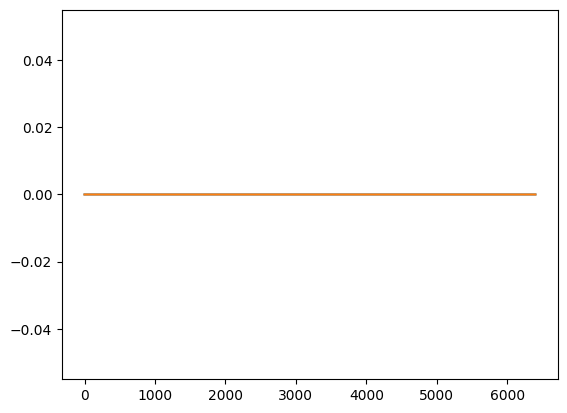

Acquisition Time: 4.138 s


In [ ]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,10)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

cfg = {
    # Experiment Setup
    "reps"          : 1,
    "soft_avgs"     : 1,
    # Parameter Setup
    "freq_rf" : 540,
    "gain" : 2000,
    "pulse_time" : 6500,
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = int(cfg["pulse_time"])
nt = int(LEN / 128)
start_time = time.time()
soc.clear_ddr4()
soc.arm_ddr4(ch = 0, nt = nt, )
print(prog)
prog.run_rounds(soc = soc)
data = soc.get_ddr4(nt = nt, start = 0)
mean_end_time = time.time()

plt.figure()
plt.plot(data)
plt.show()

print("Acquisition Time: %.3f s"%(
    mean_end_time - start_time
))

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_38f24800b8e744bfb6326c66ea9ca7fa@192.168.2.99:38083

// Program

        regwi 4, $22, 966367640;                //freq = 966367640
        regwi 4, $26, 16;                       //mode | outsel = 0b00000 | length = 16 
        synci 100;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 4, $27, 100;                      //t = 100
        set 4, 4, $22, $0, $26, $0, $26, $27;   //ch = 0, pulse @t = $27
        regwi 0, $16, 1;                        //out = 0b0000000000000001
        seti 7, 0, $16, 0;                      //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 10;                      //ch =0 out = 0 @t = 0
        regwi 0, $22, 362387865;                //freq = 362387865
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1000;                     //gain = 1000
        regwi 0, $26, 597824;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 8

100%|██████████| 1/1 [00:00<00:00, 282.69it/s]


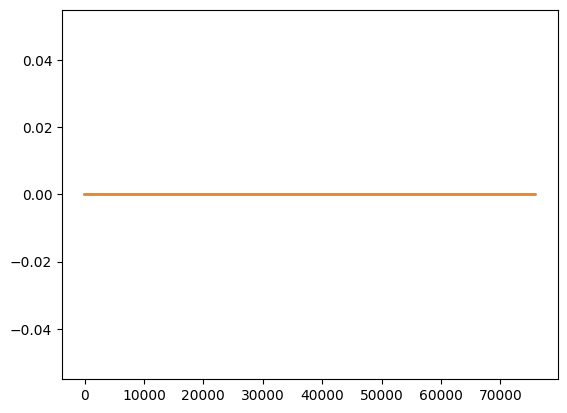

Acquisition Time: 4.144 s
SNR : inf dB
Peak @ -150.000000 MHz
Noise floor (mean)   : nan dBc/Hz
Noise floor (median) : nan dBc/Hz


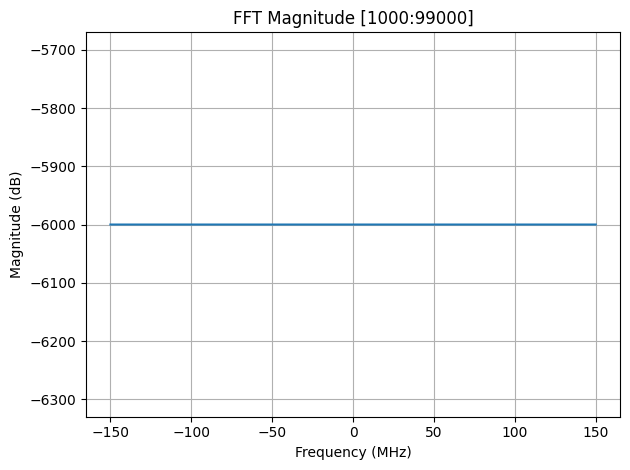

In [173]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,0,0)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

cfg = {
    # Experiment Setup
    "reps"          : 1,
    "soft_avgs"     : 1,
    # Parameter Setup
    "freq_rf" : 540,
    "gain" : 200,
    "pulse_time" : 100000,
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = int(cfg["pulse_time"] * 3 / 4) + 1024
nt = int(LEN / 128)
start_time = time.time()
soc.clear_ddr4()
soc.arm_ddr4(ch = 0, nt = nt, )
print(prog)
prog.run_rounds(soc = soc)
data = soc.get_ddr4(nt = nt, start = 0)
mean_end_time = time.time()

plt.figure()
plt.plot(data)
plt.show()

print("Acquisition Time: %.3f s"%(
    mean_end_time - start_time
))

i = [x[0] for x in data]
q = [x[1] for x in data]

res = analyze_iq_and_fft(
    (i, q),
    dt_ns=10/3,
    start_idx=1000, stop_idx=cfg["pulse_time"] - 1000, include_end=True,
    window="hann",
    signal_bins=1, guard_bins=2,
    exclude_dc_from_noise=False
)
print(f"SNR : {res['SNR_dB']:.2f} dB")
print(f"Peak @ {res['peak_freq_hz']/1e6:.6f} MHz")
print(f"Noise floor (mean)   : {res['noise_floor_mean_dBc_per_Hz']:.2f} dBc/Hz")
print(f"Noise floor (median) : {res['noise_floor_median_dBc_per_Hz']:.2f} dBc/Hz")
plot_fft_magnitude(res, title=f"FFT Magnitude [{res['start_idx']}:{res['stop_idx_inclusive']}]")
plt.show()

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_38f24800b8e744bfb6326c66ea9ca7fa@192.168.2.99:38083
Acquisition time for 1000000 averages: 31.218670129776 s


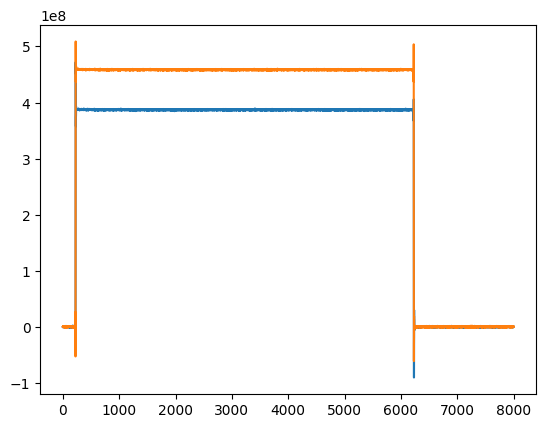

In [168]:
"""
Qick Custom IP based Trace Average test.
Signal -> Demodulation -> FIR x8 decimation -> Average Buffer (add signal itself)
In this program trace is averaged in Average Buffer on FPGA. Note that number of
average cannot exceed 2 ** 16, since each register for sample has size of 32 bits
(incomming sample has 16 bits each).
"""

class MultiPulseLoopBackExample(AveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = 8000,       # Readout length
            number_of_trace_average = cfg["reps"]
        )
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = 16, # Readout DDS multiplication length
            phrst   = 0,        # Readout DDS phase reset
        )
        self.synci(100)

    def body(self):
        cfg = self.cfg
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 0 # Readout will capture the data @ sync_t + 50
        )
        self.setup_and_pulse(
            ch      = 0,        # Generator channel
            style   = "const",    # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = int(1000), # Generator amplitude
            phrst   = 0,        # Generator DDS phase reset
            length  = 8000,
            t       = 100
        )
        self.sync_all(1000)

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,10)
soc.rfb_set_gen_rf(2,31,31)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")
soc.rfb_set_gen_filter(2,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 50000,
    "expts" : 1,
    # Parameter Setup
    "freq_rf" : 540,
    "pulse_time" : 300,
    "number_of_pulse" : 10
}
prog = MultiPulseLoopBackExample(
    soccfg,
    cfg
)
LEN = 20
data = (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
for i in range(LEN):
    data += (prog.acquire_trace_avg(soc = soc, progress = True))[0][0]
end_time = time.time()

print(f"Acquisition time for {cfg['reps']*LEN} averages: {end_time - start_time} s")
plt.figure()
plt.plot(data)
plt.show()


SNR : 57.28 dB
Peak @ 0.000000 MHz
Noise floor (mean)   : -142.04 dBc/Hz
Noise floor (median) : -144.76 dBc/Hz


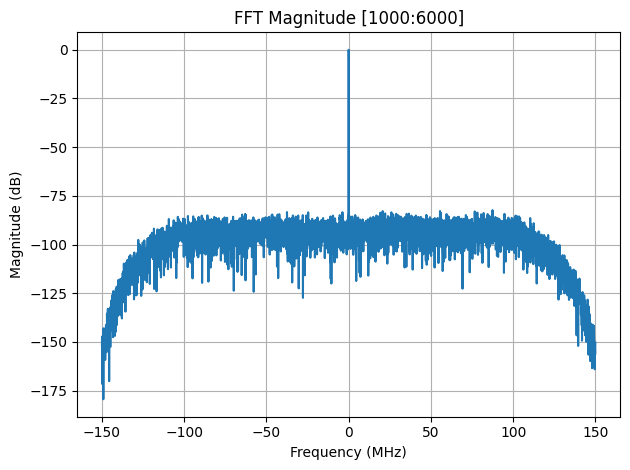

In [151]:
i = [x[0] for x in data]
q = [x[1] for x in data]

res = analyze_iq_and_fft(
    (i, q),
    dt_ns=10/3,
    start_idx=1000, stop_idx=6000, include_end=True,
    window="hann",
    signal_bins=2, guard_bins=4,
    exclude_dc_from_noise=False
)
print(f"SNR : {res['SNR_dB']:.2f} dB")
print(f"Peak @ {res['peak_freq_hz']/1e6:.6f} MHz")
print(f"Noise floor (mean)   : {res['noise_floor_mean_dBc_per_Hz']:.2f} dBc/Hz")
print(f"Noise floor (median) : {res['noise_floor_median_dBc_per_Hz']:.2f} dBc/Hz")
plot_fft_magnitude(res, title=f"FFT Magnitude [{res['start_idx']}:{res['stop_idx_inclusive']}]")
plt.show()